In [1]:
# %%
##############################################################
############### Plotting PCA components for MD reservoir network
##############################################################
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'

In [2]:
exp_name = 'data_run/MD_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
log_files = [file for file in files if 'log' in file]
print(log_files)

['log_0_1_30_1.0__12-30_14:38.npy', 'log_2_1_0.25_1.0__12-29_18:48.npy', 'log_2_2_0.25_1.0__12-29_20:01.npy']


In [16]:
# log = np.load(results_folder+exp_name+'/' +log_files[2], allow_pickle=True).item() # this is full model with mul oon.
# idx = [2200, 2205, 2803, 2807]
log = np.load(results_folder+exp_name+'/' +log_files[0], allow_pickle=True).item()  # Mul off but still with decent md_context_modulation But look context errors below.
idx = [2200, 2204, 2803, 2805]

for id in idx:
    print(f'inputs {log.Inputs[id]} MD {log.MDrates.mean(1)[id,0]}')


inputs [1.  0.  0.1 0.9] MD 0.98
inputs [0.  1.  0.1 0.9] MD 1.0
inputs [1.    0.    0.675 0.325] MD 0.045
inputs [0.  1.  0.7 0.3] MD 0.045


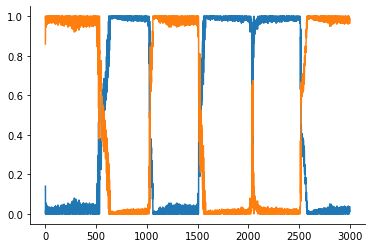

In [17]:
plt.plot(log.MDrates.mean(1))

In [14]:
# PFCrates 3000 Ntrain, 200 time steps, 500 neurons
rates = np.vstack( [log.PFCrates[id, :, :] for id in idx])
rates = rates.T
rates.shape

(500, 800)

Do datanew and datanew_sklearn have the same shape and are element-wise equal within a tolerance? True


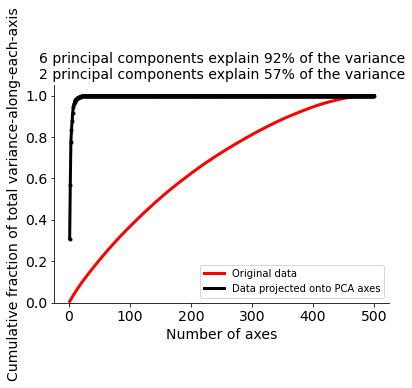

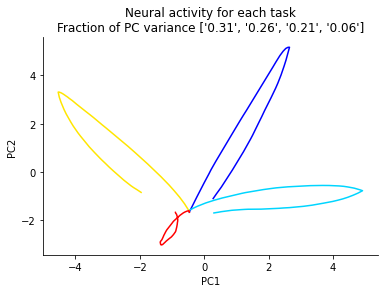

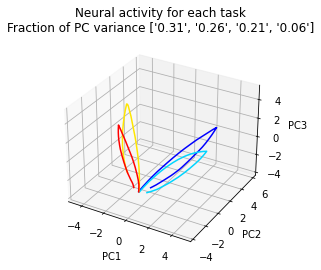

In [15]:

#-----------------------------------------------------------------------------
#                   principal component analysis (PCA)
#-----------------------------------------------------------------------------

import numpy as np
#from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from matplotlib import cm
#np.random.seed(123)# set random seed for reproducible results

# Ali, put the "firing rates" from your RNN model into the data matrix below by concatenating firing rates from each task.
# The data matrix should have shape number-of-neurons x number-of-timesteps, where number-of-timesteps = number-of-timesteps-from-task1 + number-of-timesteps-from-task2 + number-of-timesteps-from-task3 + ...
# The two arrays you need to fill are "data" and "numTforeachtask", like in the demo below.
data_task1 = np.array([[1, 2, 0, 3], [2, 4, 0, 6], [ 0, -1, 1, -2]])# numneurons x numT_task1 array
data_task2  = np.array([[1, 2, 0, 3, 5], [2, 4, 0, 6, 5], [ 0, -1, 1, -2, 6]]) + 1# numneurons x numT_task2 array
data_task3 = np.array([[1, 2, 0, 3], [2, 4, 0, 6], [ 0, -1, 1, -2]]) - 1# numneurons x numT_task3 array
numT_task1 = data_task1.shape[1]# number of timesteps in task1
numT_task2 = data_task2.shape[1]# number of timesteps in task2
numT_task3 = data_task3.shape[1]# number of timesteps in task3
numTforeachtask = np.array([numT_task1, numT_task2, numT_task3])
data = np.concatenate((data_task1, data_task2, data_task3), axis=1)# numneurons x numT array, where numT = numT_task1 + numT_task2 + ...
assert np.sum(numTforeachtask)==data.shape[1], "Error: the sum of the elements in numTforeachtask should be the same as the number of columns of data."

numT_task1 = 200
numTforeachtask = np.array([numT_task1]*len(idx))
data = rates
# Ali, you shouldn't need to modify any code below this line.
#-----------------------------------------------------------------------------

datadimensionality, numdatapoints = np.shape(data)# datadimensionality x numdatapoints array
meandata = 1/numdatapoints * np.sum(data,1)# (datadimensionality,) array
dataminusmean = data - meandata[:,np.newaxis]# datadimensionality x numdatapoints array

'''
#%% METHOD 1
covariance = 1/(numdatapoints-1) * np.matmul(dataminusmean,dataminusmean.T)# covariance*eigVec = eigVec*eigVal where * is shorthand for matrix multiplication
eigVal, eigVec = np.linalg.eigh(covariance)# the column eigVec[:, i] is the normalized eigenvector corresponding to the eigenvalue eigVal[i]. eigVec[:,-1] is the eigenvector with the largest eigenvalue     
indices = np.argsort(-eigVal)# [eigVal,indices] = sort(eigVal,'descend') sort the variances in decreasing order, so largest is first
eigVal = eigVal[indices]# (datadimensionality,) array, np.sum(np.var(data, axis=1, ddof=1)) is the same as np.sum(eigVal)
eigVec = eigVec[:,indices]# eigVec[:,i] is the ith eigenvector/principal component


#%% METHOD 2
# [u,s,v] = svd(A); A = u*s*v’; columns of u are eigenvectors of covariance matrix A*A’; rows of v’ are eigenvectors of covariance matrix A’*A; s is a diagonal matrix that has elements = sqrt(eigenvalues of A’*A and A*A’)
eigVec, eigVal, vT = np.linalg.svd(dataminusmean/np.sqrt(numdatapoints-1))# np.linalg.svd returns v transpose!
eigVal = eigVal**2# (datadimensionality,) array, largest first, np.sum(np.var(data, axis=1, ddof=1)) is the same as np.sum(eigVal)

u, eigVal, eigVecT = np.linalg.svd(dataminusmean.T/np.sqrt(numdatapoints-1))# np.linalg.svd returns v transpose!
eigVec = eigVecT.T# eigVec[:,i] is the ith eigenvector/principal component
eigVal = eigVal**2# (datadimensionality,) array, largest first, np.sum(np.var(data, axis=1, ddof=1)) is the same as np.sum(eigVal)
'''

#%% METHOD 3
modelPCA = PCA(n_components = datadimensionality).fit(data.T)
eigVal = modelPCA.explained_variance_# (datadimensionality,) array, largest is first 
eigVec = modelPCA.components_.T# eigVec[:,i] is the ith eigenvector/principal component


#%% project the data onto the first k eigenvectors/principal components
k = datadimensionality
datanew = np.matmul(eigVec[:,0:k].T, dataminusmean)# k(dimension) x numdatapoints array, np.var(datanew, axis=1, ddof=1) is the same as eigVal
datanew_sklearn = modelPCA.transform(data.T).T# n_components x numdatapoints array, input is data not dataminusmean!
print(f"Do datanew and datanew_sklearn have the same shape and are element-wise equal within a tolerance? {datanew.shape == datanew_sklearn.shape and np.allclose(datanew, datanew_sklearn)}")


fraction = eigVal/np.sum(eigVal)# fraction of variance explained by each eigenvector
VARIANCEEXPLAINED = 0.9# a number from 0 to 1
numPCs90 = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
numPCs90 = numPCs90[0]
VARIANCEEXPLAINED = 0.5# a number from 0 to 1
numPCs50 = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
numPCs50 = numPCs50[0]


# The sum of the variance-along-each-axis is preserved under a rotation of the axes, e.g. np.sum(eigVal) = np.sum(np.var(data, axis=1, ddof=1))
# In other words, the variance of neuron 1 over time + variance of neuron 2 over time + ... + variance of last neuron over time = sum of variances after projecting data onto each principal component
var_data = np.var(data.copy(), axis=1, ddof=1)# not sorted
indices = np.argsort(-var_data)# sort the variances in decreasing order, so largest is first
var_data = var_data[indices]# largest variance is first                  
cumulative_fraction_var_data = np.cumsum(var_data) / np.sum(var_data)

var_datanew = np.var(datanew.copy(), axis=1, ddof=1)# 
cumulative_fraction_var_datanew = np.cumsum(var_datanew) / np.sum(eigVal)

fig, ax = plt.subplots()# cumulative fraction of total variance-along-each-axis
fontsize = 14
handle1 = ax.plot(np.arange(1,datadimensionality+1), cumulative_fraction_var_data, 'r-', linewidth=3)
handle2 = ax.plot(np.arange(1,datadimensionality+1), np.cumsum(eigVal)/np.sum(eigVal), 'k-', linewidth=3)
handle3 = ax.plot(np.arange(1,k+1), cumulative_fraction_var_datanew, 'k.')# fraction of variance kept in k-dimensional projection
ax.legend(handles=[handle1[0],handle2[0]], labels=['Original data','Data projected onto PCA axes'], loc='best', frameon=True)
ax.set_xlabel('Number of axes', fontsize=fontsize)
ax.set_ylabel('Cumulative fraction of total variance-along-each-axis', fontsize=fontsize)
ax.set_title(f'{numPCs90} principal components explain {100*np.sum(eigVal[0:numPCs90])/np.sum(eigVal):.0f}% of the variance\n{numPCs50} principal components explain {100*np.sum(eigVal[0:numPCs50])/np.sum(eigVal):.0f}% of the variance', fontsize=fontsize)
ax.set_xlim(xmin=None, xmax=None); ax.set_ylim(ymin=0, ymax=None)
#ax.set_xticks(np.arange(1,datadimensionality+1)); ax.set_xticklabels(np.arange(1,datadimensionality+1))
#ax.set_yticks([0, 0.5, 1]); ax.set_yticklabels([0, 0.5, 1])
ax.tick_params(axis='both', labelsize=fontsize)
#fig.savefig('%s/PCA_variance%g.pdf'%(figdir,1), bbox_inches='tight')# add bbox_inches='tight' to keep title from being cutoff
#import sys; sys.exit()# stop script at current line


#%%
# Plot the neural trajectories for each task 

numtasks = numTforeachtask.shape[0]
jet = cm.get_cmap('jet', numtasks)
colormap = jet(range(numtasks))# (numtasks, 4) array columns 1,2,3 are the RGB values, column 4 sets the transparency/alpha, datapoint[0] has color colormap[0,:]
colormap[0,:] = np.array([0, 0, 1, 1]); colormap[-1,:] = np.array([1, 0, 0, 1]);# colormap[0,:] is blue, colormap[-1,:] is red
 

fig, ax = plt.subplots()# 2D PCA trajectory
istart = np.concatenate((np.array([0]), np.cumsum(numTforeachtask)[0:-1]))# istart[j] is the starting index of the neural trajectory for task j
iend = np.cumsum(numTforeachtask)# iend[j] is the ending index of the neural trajectory for task j 
for i in range(numtasks):
    ax.plot(datanew[0,istart[i]:iend[i]], datanew[1,istart[i]:iend[i]], '-', c=colormap[i,:])  
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title("Neural activity for each task\nFraction of PC variance {t}".format(t = list(map('{:.2f}'.format,fraction[0:4]))))# https://stackoverflow.com/questions/52823128/unsupported-format-string-passed-to-numpy-ndarray


plt.figure()# 3D PCA trajectory
ax = plt.axes(projection='3d')
istart = np.concatenate((np.array([0]), np.cumsum(numTforeachtask)[0:-1]))# istart[j] is the starting index of the neural trajectory for task j
iend = np.cumsum(numTforeachtask)# iend[j] is the ending index of the neural trajectory for task j 
for i in range(numtasks):
    ax.plot3D(datanew[0,istart[i]:iend[i]], datanew[1,istart[i]:iend[i]], datanew[2,istart[i]:iend[i]], '-', c=colormap[i,:])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("Neural activity for each task\nFraction of PC variance {t}".format(t = list(map('{:.2f}'.format,fraction[0:4]))))# https://stackoverflow.com/questions/52823128/unsupported-format-string-passed-to-numpy-ndarray
# Create cubic bounding box to simulate equal aspect ratio
X = datanew[0,:]
Y = datanew[1,:]
Z = datanew[2,:]
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')
plt.grid()
plt.show()
# https://stackoverflow.com/questions/49027061/matplotlib-3d-remove-axis-ticks-draw-upper-edge-border
# https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to


